In [81]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns

from scipy.optimize import minimize
from QuantLib import *

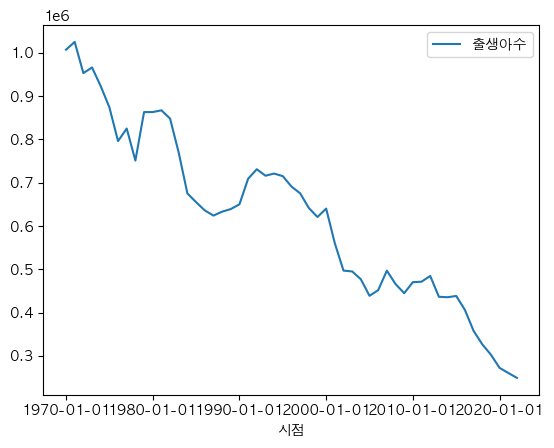

In [82]:
y = pd.read_csv("../preprocess_data/한국출생아.csv", index_col = 0)
y.plot()
plt.show()

In [83]:
y.head()

,출생아수
시점,
1970-01-01,1007000.0
1971-01-01,1025000.0
1972-01-01,953000.0
1973-01-01,966000.0
1974-01-01,923000.0


In [84]:
ydat = np.array(y)

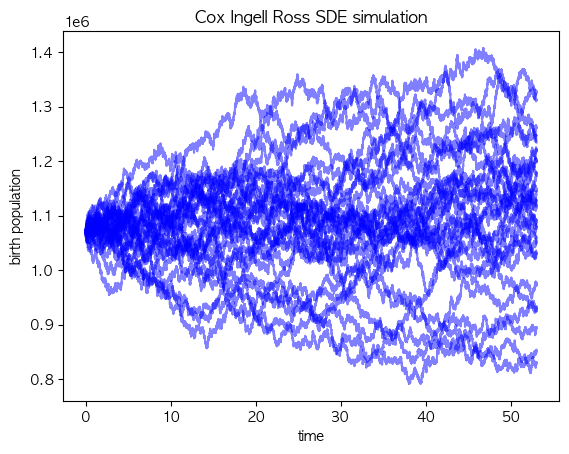

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# CIR 모형의 시간에 따라 변하는 파라미터를 정의하는 함수
def alpha_t(t, r, k):
    return r + k * t

# CIR 모형 시뮬레이션을 위한 함수
def simulate_cir_population(T, num_steps, num_simulations, initial_population, params):
    r, k, mu, sigma = params
    dt = T / num_steps
    t_values = np.linspace(0, T, num_steps + 1)

    # 각 시뮬레이션에서의 결과를 저장할 배열
    population_all = np.zeros((num_simulations, num_steps + 1))

    for j in range(num_simulations):
        population = np.zeros(num_steps + 1)
        population[0] = initial_population

        for i in range(num_steps):
            alpha = alpha_t(t_values[i], r, k)
            dW = np.random.normal(0, np.sqrt(dt))
            population[i + 1] = (
                population[i] + alpha * (mu - population[i] / initial_population) * dt + sigma * np.sqrt(population[i]) * dW
            )

        population_all[j, :] = population

    return population_all

# 파라미터 설정
T = 53
num_steps = 53*365 # dt
num_simulations = 30 # number of sample
initial_population = 1070000  # 초기 인구

r0 = -0.1  # 초기 증가율
k0 = -0.1  # 시간에 따른 증가율
mu0 = 0.5 # 평균
sigma0 = 20  # 변동성
init_params = [r0, k0, mu0, sigma0]

t_values = np.linspace(0, T, num_steps + 1)
T_values = np.linspace(53+1, num_steps, 53).astype(int)


# CIR 모형 시뮬레이션
population_all = simulate_cir_population(T, num_steps, num_simulations, initial_population, init_params)

# 결과 시각화 (시뮬레이션 결과 중 5개만 표시)
for j in range(num_simulations):
    plt.plot(t_values, population_all[j, :], label=f'Simulation {j + 1}', color = "blue", alpha = 0.5)

plt.title('Cox Ingell Ross SDE simulation')
plt.xlabel('time')
plt.ylabel('birth population')
plt.show()

# optimization
result = minimize(lambda params: -np.sum((simulate_cir_population(T, num_steps, num_simulations, initial_population, params)[:,T_values] - y['출생아수'].values)**2), init_params, method = "BFGS")

In [86]:
y.tail()

,출생아수
시점,
2018-01-01,326800.0
2019-01-01,302700.0
2020-01-01,272300.0
2021-01-01,260600.0
2022-01-01,249100.0


In [87]:
# extract the optimized hyper-parameters
r_fit, k_fit, mu_fit, sigma_fit = result.x

# print the estimated parameters
print(f"Estimated r + k*t (alpha(t)) : {r_fit, k_fit}")
print(f"Estimated mu : {mu_fit}")
print(f"Estimated sigma : {sigma_fit}")

# simulate CIR process for the next 50 times steps(500 samples)
future_steps = 50
predicted_data_samples_cir = simulate_cir_population(future_steps,
                                                     num_steps = future_steps*365,
                                                     num_simulations = 1000,
                                                     initial_population = 249100.0,
                                                     params = [r_fit, k_fit, mu_fit, sigma_fit])

Estimated r + k*t (alpha(t)) : (-0.09996140394383604, -0.09997081934677565)
Estimated mu : 0.5000019334126261
Estimated sigma : 20.000042765358607


In [88]:
predicted_data_samples_cir.shape

(1000, 18251)

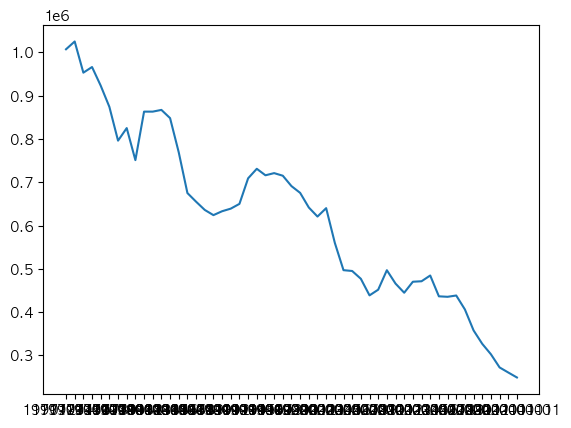

In [89]:
# Plot the original data and the mean of predicted CIR values
plt.plot(y.index, y['출생아수'], label='Original Data')

In [90]:
t_values_pred = np.linspace(1, future_steps, future_steps*365+1)

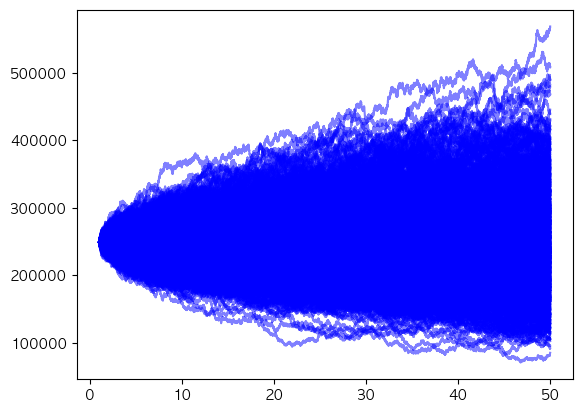

In [91]:
for j in range(1000):
    plt.plot(t_values_pred, predicted_data_samples_cir[j, :], label=f'Simulation {j + 1}', color = "blue", alpha = 0.5)

Text(0.5, 1.0, 'Stochastic Process of BIRTH POPULATION 50 years with daily update')

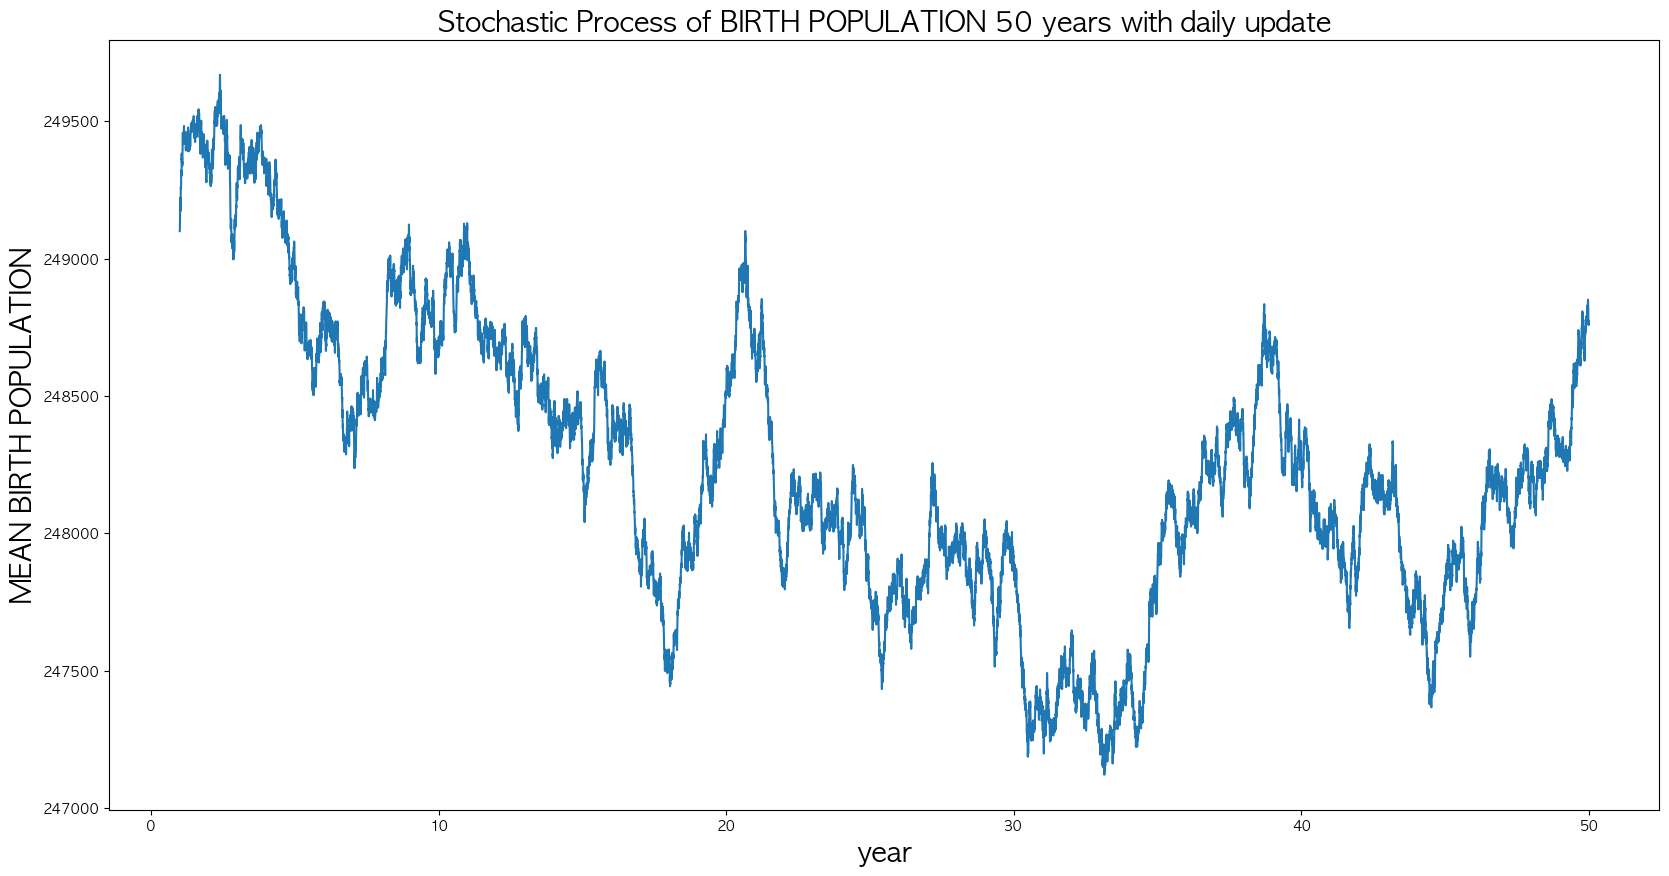

In [92]:
plt.figure(figsize = (20,10))
plt.plot(t_values_pred, np.mean(predicted_data_samples_cir, axis = 0))
plt.xlabel("year", fontsize = 20)
plt.ylabel("MEAN BIRTH POPULATION", fontsize = 20)
plt.title("Stochastic Process of BIRTH POPULATION 50 years with daily update", fontsize = 20)

Text(0.5, 1.0, 'Stochastic Process of BIRTH POPULATION 50 years with daily update (median)')

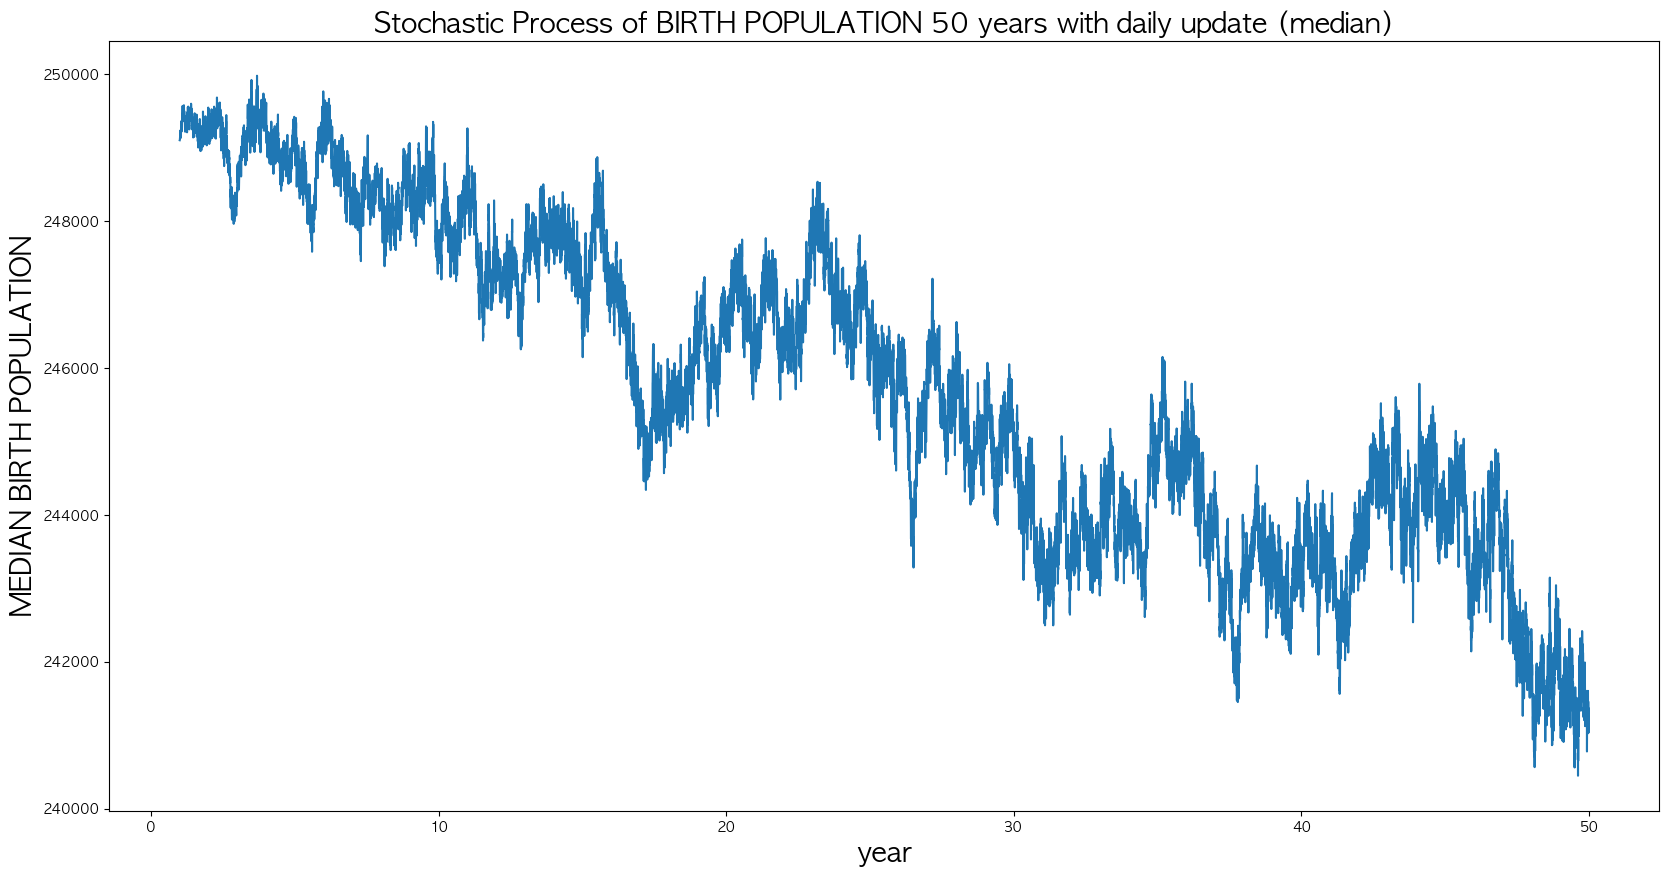

In [93]:
plt.figure(figsize = (20,10))
plt.plot(t_values_pred, np.median(predicted_data_samples_cir, axis = 0))
plt.xlabel("year", fontsize = 20)
plt.ylabel("MEDIAN BIRTH POPULATION", fontsize = 20)
plt.title("Stochastic Process of BIRTH POPULATION 50 years with daily update (median)", fontsize = 20)

In [94]:
len(t_values_pred)

18251

In [95]:
np.median(predicted_data_samples_cir)

246844.8986961585

<Axes: xlabel='date'>

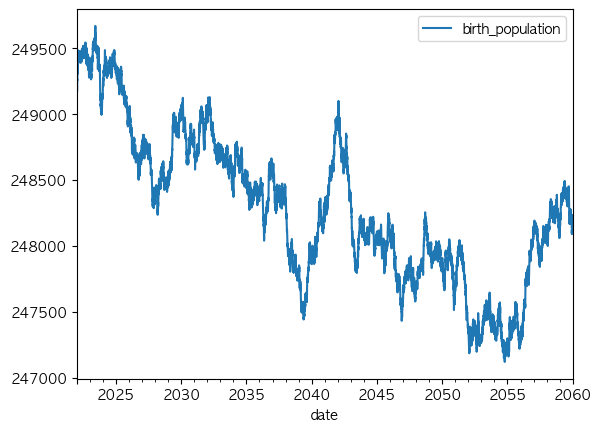

In [99]:
start_date = '2022-01-01'
end_date = '2080-01-01'
dates = pd.date_range(start=start_date, end=end_date)

df = pd.DataFrame(np.mean(predicted_data_samples_cir, axis = 0), columns = ["birth_population"])
df2 = pd.DataFrame(dates, columns = ['date'])
df2 = pd.concat([df2, df], axis = 1)
df2.set_index('date', inplace = True)
df2 = df2.loc['2022-01-01':'2060-01-01']
df2.plot()

In [101]:
df2['year'] = df2.index.year.astype(str)
df2.set_index('year', inplace=True)
df2 = df2[~df2.index.duplicated(keep='first')]
df2.index = pd.to_datetime(df2.index.astype(str))
df2 = df2.astype('int')
df2.to_csv("../preprocess_data/한국출생아_미래_draft.csv")

In [97]:
T_values_pred = np.linspace(future_steps+1, future_steps*365, future_steps).astype(int)

In [19]:
T_values_pred.__len__()

50

In [20]:
predicted_data_samples_cir[:,T_values_pred].shape

(1000, 50)

In [21]:
T_values_pred[9]

3393

/var/folders/k8/xm42xp_16cs6fgtvp6ymr9l40000gn/T/ipykernel_73327/2884979032.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(year10pred)


<Axes: ylabel='Density'>

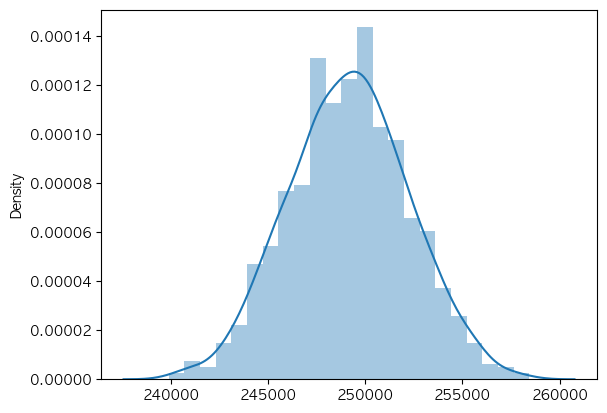

In [26]:
# 10 year future distribution for next day
year10pred = predicted_data_samples_cir[:,T_values_pred[9]]
sns.distplot(year10pred)

# Different Optimization (robust to initial parameter setting)


In [248]:
# optimization
result_CG = minimize(lambda params: -np.sum((simulate_cir_population(T, num_steps, num_simulations, initial_population, params)[:,T_values] - y['출생아수'].values)**2), init_params, method = "CG")

In [249]:
# extract the optimized hyper-parameters
r_fit2, k_fit2, mu_fit2, sigma_fit2 = result_CG.x

# print the estimated parameters
print(f"Estimated r + k*t (alpha(t)) : {r_fit2, k_fit2}")
print(f"Estimated mu : {mu_fit2}")
print(f"Estimated sigma : {sigma_fit2}")

# simulate CIR process for the next 50 times steps(500 samples)
future_steps = 50
predicted_data_samples_cir2 = simulate_cir_population(future_steps,
                                                     num_steps = future_steps*365,
                                                     num_simulations = 1000,
                                                     initial_population = 249100.0,
                                                     params = [r_fit2, k_fit2, mu_fit2, sigma_fit2])

Estimated r + k*t (alpha(t)) : (-0.10001153890530366, -0.09999056117498592)
Estimated mu : 0.49998826470672936
Estimated sigma : 2.0000217900768185


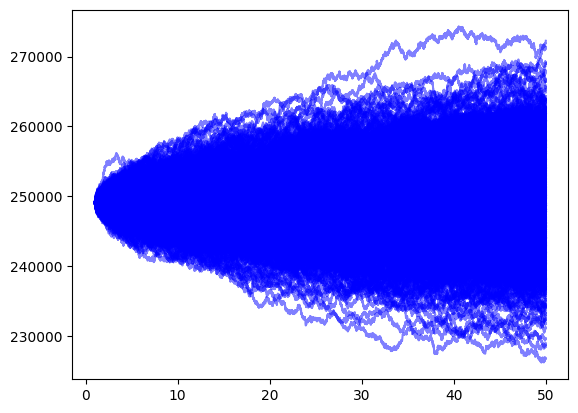

In [250]:
for j in range(1000):
    plt.plot(t_values_pred, predicted_data_samples_cir2[j, :], label=f'Simulation {j + 1}', color = "blue", alpha = 0.5)

Text(0.5, 1.0, 'Stochastic Process of BIRTH POPULATION 50 year s-  Optim option: CG')

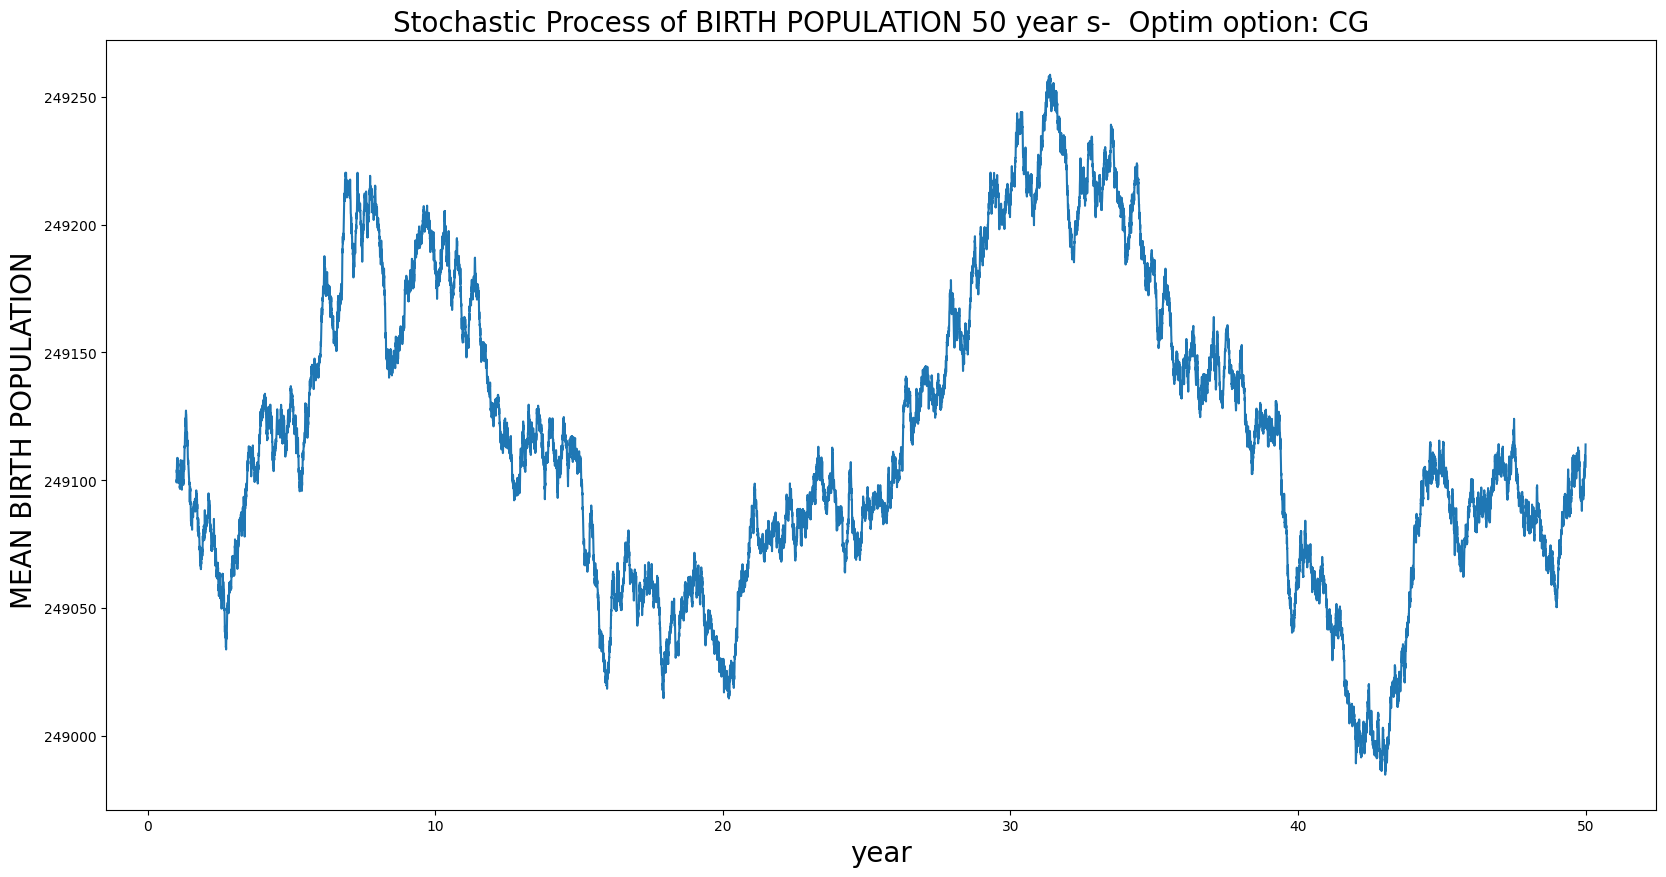

In [251]:
plt.figure(figsize = (20,10))
plt.plot(t_values_pred, np.mean(predicted_data_samples_cir2, axis = 0))
plt.xlabel("year", fontsize = 20)
plt.ylabel("MEAN BIRTH POPULATION ", fontsize = 20)
plt.title("Stochastic Process of BIRTH POPULATION 50 year s-  Optim option: CG", fontsize = 20)

Text(0.5, 1.0, 'Stochastic Process of BIRTH POPULATION 50 years with daily update (median)')

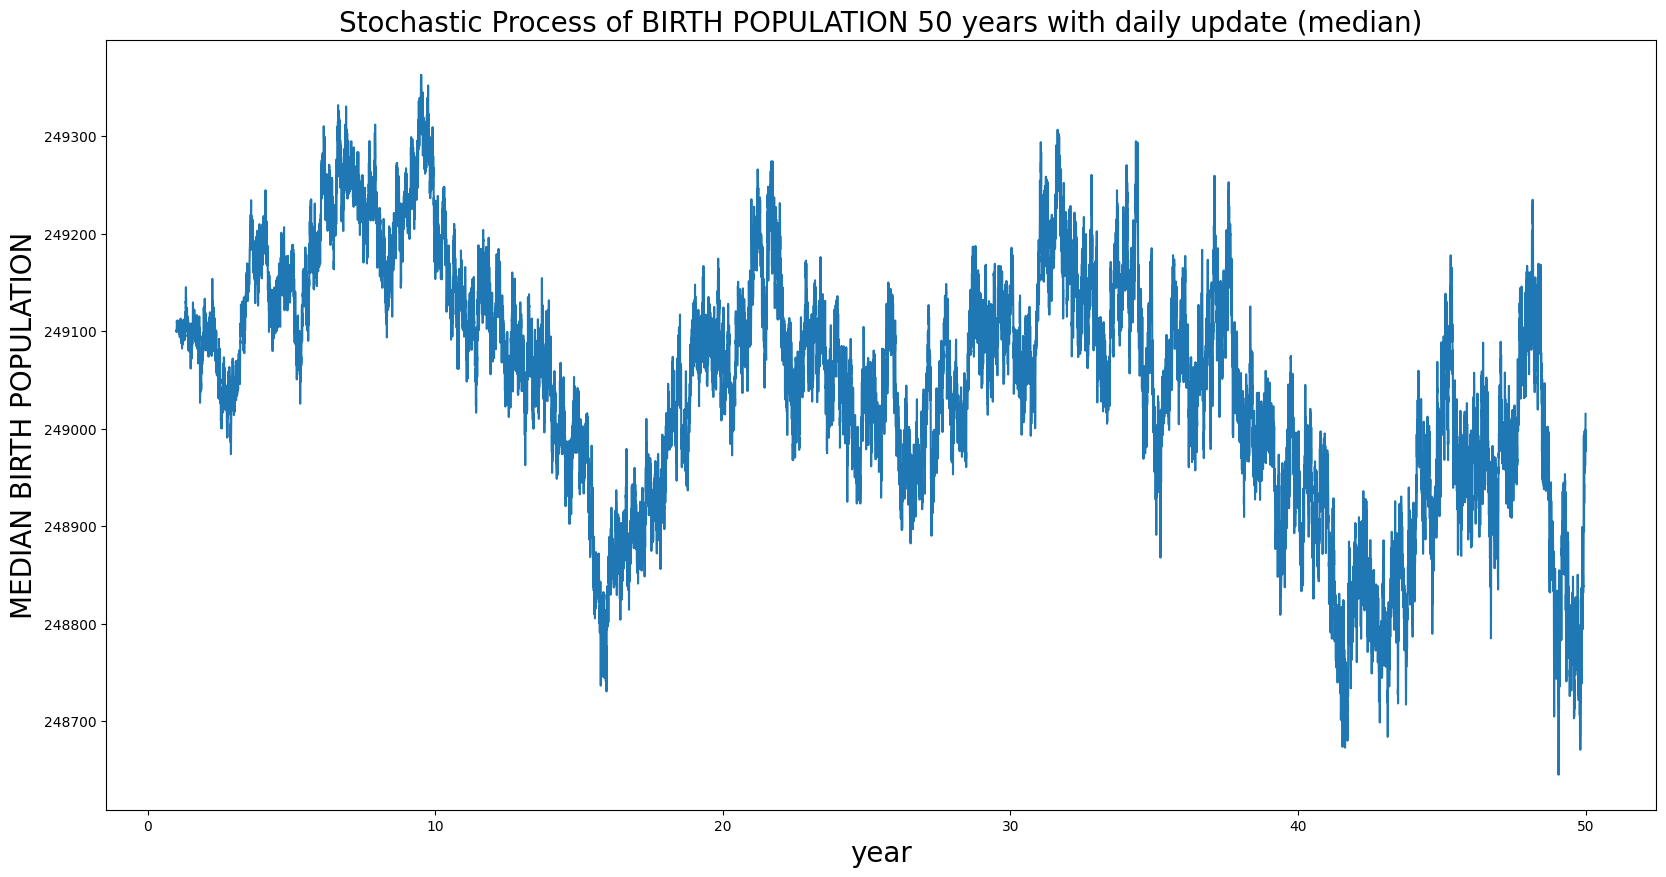

In [252]:
plt.figure(figsize = (20,10))
plt.plot(t_values_pred, np.median(predicted_data_samples_cir2, axis = 0))
plt.xlabel("year", fontsize = 20)
plt.ylabel("MEDIAN BIRTH POPULATION", fontsize = 20)
plt.title("Stochastic Process of BIRTH POPULATION 50 years with daily update (median)", fontsize = 20)

# RKHS(banned)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPy

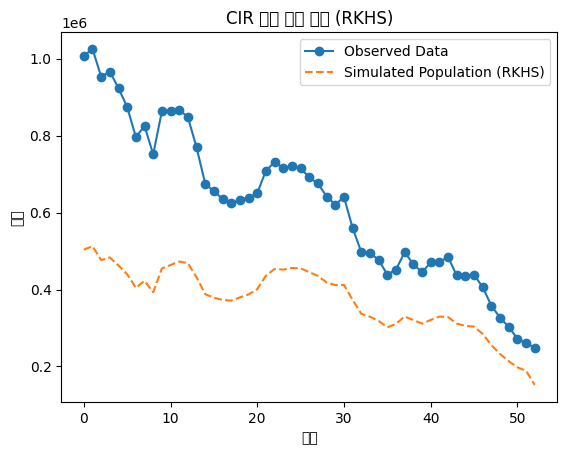

In [253]:
import numpy as np
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

# CIR 모형의 시간에 따라 변하는 파라미터를 정의하는 함수
def alpha_t(t, r, k):
    return r + k * t

# CIR 모형 시뮬레이션 함수 (인구 예측용으로 수정)
def simulate_cir_population(T, num_steps, initial_population, r, k, sigma):
    dt = T / num_steps
    t_values = np.linspace(0, T, num_steps + 1)

    # 결과를 저장할 배열
    population = np.zeros(num_steps + 1)
    population[0] = initial_population

    for i in range(num_steps):
        alpha = alpha_t(t_values[i], r, k)
        dW = np.random.normal(0, np.sqrt(dt))
        population[i + 1] = (
            population[i] + alpha * (1 - population[i] / initial_population) * dt + sigma * np.sqrt(population[i]) * dW
        )

    return t_values, population

# 관찰된 데이터
observed_data = np.array(y)

# 초기 추정값 설정
initial_guess = [0.01, 0.0001, 0.1]  # r, k, sigma

# CIR 모형 시뮬레이션 결과를 사용하여 특징 매핑 함수를 생성
def feature_mapping(t_values, r, k, sigma):
    features = np.zeros((len(t_values), 3))
    for i, t in enumerate(t_values):
        alpha = alpha_t(t, r, k)
        features[i, 0] = alpha
        features[i, 1] = np.sqrt(t)
        features[i, 2] = sigma * np.sqrt(t)
    return features

# CIR 모델 학습 및 시뮬레이션
T = len(observed_data) - 1
num_steps = T
initial_population = observed_data[0]

# 특징 매핑
features = feature_mapping(np.arange(T + 1), *initial_guess)

# 커널 트릭을 사용하여 Kernel Ridge Regression 모델 생성
kernel_ridge_model = KernelRidge(kernel='rbf', gamma=100)
kernel_ridge_model.fit(features, observed_data)

# 시뮬레이션 결과 예측
t_values_sim, _ = simulate_cir_population(T, num_steps, initial_population, *initial_guess)
features_sim = feature_mapping(t_values_sim, *initial_guess)
population_pred = kernel_ridge_model.predict(features_sim)

# 시뮬레이션 결과 시각화
plt.plot(np.arange(T + 1), observed_data, label='Observed Data', marker='o')
plt.plot(np.arange(T + 1), population_pred, label='Simulated Population (RKHS)', linestyle='--')
plt.title('CIR 모델 학습 결과 (RKHS)')
plt.xlabel('시간')
plt.ylabel('인구')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPy

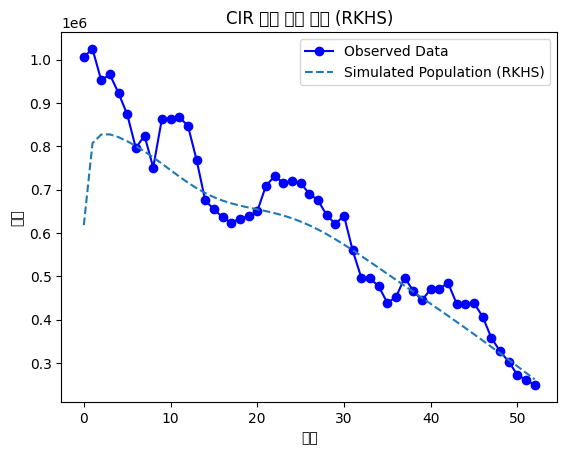

In [254]:
import numpy as np
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

# CIR 모형의 시간에 따라 변하는 파라미터를 정의하는 함수
def alpha_t(t, r, k):
    return r + k * t

# CIR 모형 시뮬레이션 함수 (인구 예측용으로 수정)
def simulate_cir_population(T, num_steps, initial_population, r, k, sigma):
    dt = T / num_steps
    t_values = np.linspace(0, T, num_steps + 1)

    # 결과를 저장할 배열
    population = np.zeros(num_steps + 1)
    population[0] = initial_population

    for i in range(num_steps):
        alpha = alpha_t(t_values[i], r, k)
        dW = np.random.normal(0, np.sqrt(dt))
        population[i + 1] = (
            population[i] + alpha * (1 - population[i] / initial_population) * dt + sigma * np.sqrt(population[i]) * dW
        )

    return t_values, population

# 관찰된 데이터
observed_data = np.array(y)

# 초기 추정값 설정
initial_guess = [0.01, 0.0001, 0.1]  # r, k, sigma

# CIR 모형 시뮬레이션 결과를 사용하여 특징 매핑 함수를 생성
def feature_mapping(t_values, r, k, sigma):
    features = np.zeros((len(t_values), 3))
    for i, t in enumerate(t_values):
        alpha = alpha_t(t, r, k)
        features[i, 0] = alpha
        features[i, 1] = np.sqrt(t)
        features[i, 2] = sigma * np.sqrt(t)
    return features

# 주기적 커널을 사용한 커널 리지 회귀 모델 생성
kernel_ridge_model = KernelRidge(kernel='rbf', gamma = 0.5)

# CIR 모델 학습 및 시뮬레이션
T = len(observed_data) - 1
num_steps = T
initial_population = observed_data[0]

# 특징 매핑
features = feature_mapping(np.arange(T + 1), *initial_guess)

# 커널 트릭을 사용하여 Kernel Ridge Regression 모델 생성
kernel_ridge_model.fit(features, observed_data)

# 시뮬레이션 결과 예측
t_values_sim, _ = simulate_cir_population(T, num_steps, initial_population, *initial_guess)
features_sim = feature_mapping(t_values_sim, *initial_guess)
population_pred = kernel_ridge_model.predict(features_sim)

# 시뮬레이션 결과 시각화
plt.plot(np.arange(T + 1), observed_data,  color = "blue", label='Observed Data', marker='o')
plt.plot(np.arange(T + 1), population_pred, label='Simulated Population (RKHS)', linestyle='--')
plt.title('CIR 모델 학습 결과 (RKHS)')
plt.xlabel('시간')
plt.ylabel('인구')
plt.legend()
plt.show()



In [255]:
import numpy as np
from scipy.optimize import minimize_scalar

# 주어진 데이터
y_data = np.array(y)

# Lipschitz 연속성을 만족하는 함수 생성
def lipschitz_continuous_function(x, y_data, lipschitz_constant):
    def lipschitz_function(t):
        # 목적 함수: 주어진 데이터와의 차이의 제곱의 합
        difference = y_data - t
        return np.sum(difference**2) + lipschitz_constant * np.sum(np.abs(x - t))

    # 최적화 문제를 푸는 함수
    result = minimize_scalar(lipschitz_function, bounds=(min(y_data), max(y_data)), method='bounded')
    optimal_input = result.x
    return optimal_input

# Lipschitz 연속성을 만족하는 함수 생성
lipschitz_constant = 2  # Lipschitz 상수
optimal_input = lipschitz_continuous_function(y_data, y_data, lipschitz_constant)

print("Optimal Input for Lipschitz Function:", optimal_input)


Optimal Input for Lipschitz Function: 621537.8679018544


# Goodness of FIt Test for SDE model

In [256]:
import re
import scipy.stats
from scipy.stats import chi2

import math
import warnings
import statsmodels.api as sm
import pylab as py
warnings.filterwarnings('ignore')

def fit_distribution(o, e, pct_upper, pct_lower, obs_num=T, alpha = 0.05):
  """
  for given SDE with fitted hyper-parameters,
  perform Chi-Square Goodenss of Fit Test within data

  for testing, we use mean function of SDE simulation

  Observation is SDE in discretized values
  Expectation is data
  """
  o =
  chi_square_statistics = []
  chi_sqaure_statistics_alpha_upper = []
  chi_sqaure_statistics_alpha_lower = []
  data_follows_candidate = [] # H0 : data follows well with the given distribution

  # default is 1001 bins
  # user-defined hyper-parameter that result of chi-square test depends on
  # need to be adjusted properly (caution)
  percentile_bins = np.linspace(0,100,bin_num)
  percentile_cutoffs = np.percentile(y_std, percentile_bins) # 0 ~ 100. 소수점 1자리
  observed_frequency, bins = (np.histogram(y_std, bins = percentile_cutoffs))
  cum_observed_frequency = np.cumsum(observed_frequency)



    # Get expected counts in percentile bins for calculating Chi-Square test
    # cdf of fitted distribution across bins
    cdf_expected = dist.cdf(percentile_cutoffs, *param)
    expected_frequency = []
    for bin in range(len(percentile_bins)-1):
      expected_cdf_area = cdf_expected[bin+1] - cdf_expected[bin]
      expected_frequency.append(expected_cdf_area)

    # Chi-Square Statistics
    # H0 : data fits well with the expected value per bin which follows known distribution
    param_size = len(param)
    df = (bin_num -1) -1 - param_size
    chi_sqaure_statistics_alpha_upper.append(chi2(df).ppf(1-0.5*alpha))
    chi_sqaure_statistics_alpha_lower.append(chi2(df).ppf(0.5*alpha))

    expected_frequency = np.array(expected_frequency) * y_size
    cum_expected_frequency = np.cumsum(expected_frequency)
    ss = round(sum(((cum_expected_frequency - cum_observed_frequency)**2)/cum_expected_frequency), 3)
    chi_square_statistics.append(ss)

    if chi_sqaure_statistics_alpha_lower < chi_square_statistics < chi_sqaure_statistics_alpha_upper:
      data_follows_candidate.append(True)
    else :
      data_follows_candidate.append(False)

  # Sort by minimum chi-square statistics
  result = pd.DataFrame()
  result['Distribution'] = candidate_dist
  result['Chi-Square'] = chi_square_statistics
  result['Data follows candidate'] = data_follows_candidate
  result.sort_values(['Chi-Square'], inplace = True)

  print("\n Distributions listed by Betterment of fit:")
  print(".............................................")
  print(result)


SyntaxError: ignored